<h1><center>Fake News Detection</h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('fake_or_real_news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [3]:
#Renaming column
df.rename( columns={'Unnamed: 0':'ID'}, inplace=True )

In [4]:
df.shape

(6335, 4)

In [5]:
df.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [7]:
#Checking null values
df.isnull().sum()

ID       0
title    0
text     0
label    0
dtype: int64

<p><b>Counting number of fake and real news</b></p>

In [8]:
#creatung grouop by object to identify real vs fake news
d=df.groupby('label')

In [9]:
fake_real=pd.DataFrame(df.label.value_counts())

In [10]:
fake_real

,count
label,
REAL,3171
FAKE,3164


<b>Checking Duplicate videos</b>

In [11]:
#finidng and dropping duplicate values
df[df['title'].duplicated()]

,ID,title,text,label
843,9998,The Israeli Trumpess,WHAT WILL Donald Trump do if he loses the elec...,FAKE
1464,10010,Michael Moore Owes Me $4.99,"28, 2016 | Reviews Michael Moore in New Yo...",FAKE
1492,2697,"University of Missouri, please immediately fir...",To watch the video of photographer Tim Tai get...,REAL
1494,9264,"Meteor, space junk, rocket? Mysterious flash h...","Meteor, space junk, rocket? Mysterious flash h...",FAKE
1603,7007,Hillary’s “Big Tent” is Obama’s “Grand Bargain...,B y BAR executive editor Glen Ford B arack Oba...,FAKE
...,...,...,...,...
6231,9542,Schools All Over America Are Closing On Electi...,"in: Politics , Sleuth Journal , Special Intere...",FAKE
6233,7171,North Korea Threatens ‘Sacred’ Nuclear War Aga...,Email \nNorth Korea’s Foreign Ministry slammed...,FAKE
6303,7437,The Deceptive Nature of Hillary Clinton is Rig...,Posted by David Risselada \nMuch to the surpri...,FAKE
6307,9013,US abstains from UN vote calling for end to Cu...,US abstains from UN vote calling for end to Cu...,FAKE


In [12]:
df.drop_duplicates(subset='title', keep='last', inplace=True)

In [13]:
#dropping irrelevant columns
df.drop(['ID','title'],axis=1,inplace=True)

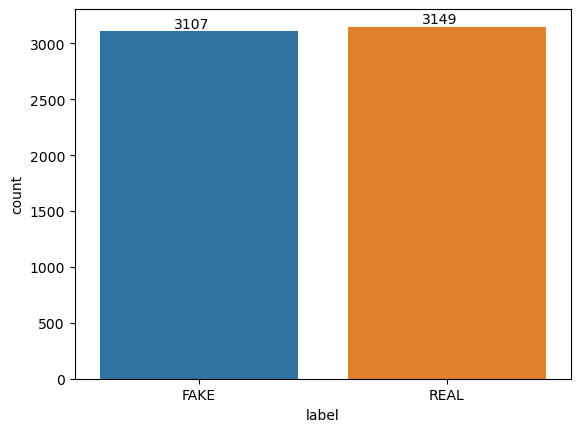

In [14]:
#plotting count of real and fake news
ax=sns.countplot(data=df,x='label')
for p in ax.patches:
        ax.annotate(format(p.get_height(),'1.0f'), (p.get_x()+0.3, p.get_height()+30))

<p><b>Since it is a balanced data, we can move ahead with the model development</b></p>

In [15]:
portstemmer=PorterStemmer()#To find the root winder, stemmer is used

In [16]:
'''There is no inbuilt fucntion to remove unwanted characters, labels, strings etc. So we need to define a function
to remove those characters and then joining them to form a single list'''
def stemming(news_text):
    stemmed_content=re.sub('[^a-zA-Z]', ' ', news_text)
    stemmed_content=stemmed_content.lower()
    stemmed_content=stemmed_content.split()
    stemmed_content=[portstemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]            
    stemmed_content=' '.join(stemmed_content)
    return stemmed_content

In [17]:
#We can create a sample out of given dataset based on our conevenience and computational speed. Just change 'n' value
sample_data=df.sample(n=1000, random_state=10)
sample_data['text']= sample_data['text'].apply(stemming)

In [18]:
#Creating two dataframes of dependent and independent features
X=sample_data['text']
y=sample_data['label'].apply(lambda x:1 if x=='FAKE' else 0)

In [19]:
#Partioning data into training and test data
X_train , X_test , y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [20]:
vectorizer=TfidfVectorizer()#We need to convert strings to vectors so that ML algorithms can act upon them as strings are not readable by ML models
#Fitting the data
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

In [21]:
models_evaluation=[]
prediction_report=[]
auc_score=[]
target_names=['REAL','FAKE']
model_evaluation=[]
classification_report=[]
cm=[]
AUC_score=[]
model_list={'Random Forest Classifier':RandomForestClassifier(n_estimators=100),
            'Logistic Regression':LogisticRegression(),
           'SVC':SVC(random_state=101,probability=True),
            'KNN':KNeighborsClassifier(n_neighbors=7),
            'XG Boost':XGBClassifier(),
           'Decision Tree Classifier':DecisionTreeClassifier(),
           'MLPClassifier':MLPClassifier(),
           'AdaBoost':AdaBoostClassifier()}

for name,model in model_list.items():
    
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    prediction_report.append(prediction)
    accuracy = accuracy_score(y_test, prediction)*100
    cm.append(confusion_matrix(y_test,prediction))
    model_evaluation.append([name,accuracy,cm])
    print('Accuracy of {} is {}%'.format(name,accuracy),'\n\n')
#     print(classification_report(y_test,prediction_report))

Accuracy of Random Forest Classifier is 85.0% 


Accuracy of Logistic Regression is 86.5% 


Accuracy of SVC is 87.5% 


Accuracy of KNN is 51.5% 


Accuracy of XG Boost is 89.0% 


Accuracy of Decision Tree Classifier is 74.5% 


Accuracy of MLPClassifier is 86.0% 


Accuracy of AdaBoost is 86.5% 




In [22]:
model_info=pd.DataFrame(model_evaluation,columns=['Classifier','Accuracy','Confusion_matrix'])
model_info=model_info.sort_values(by='Accuracy')
model_info

,Classifier,Accuracy,Confusion_matrix
3,KNN,51.5,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."
5,Decision Tree Classifier,74.5,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."
0,Random Forest Classifier,85.0,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."
6,MLPClassifier,86.0,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."
1,Logistic Regression,86.5,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."
7,AdaBoost,86.5,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."
2,SVC,87.5,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."
4,XG Boost,89.0,"[[[90, 13], [17, 80]], [[86, 17], [10, 87]], [..."


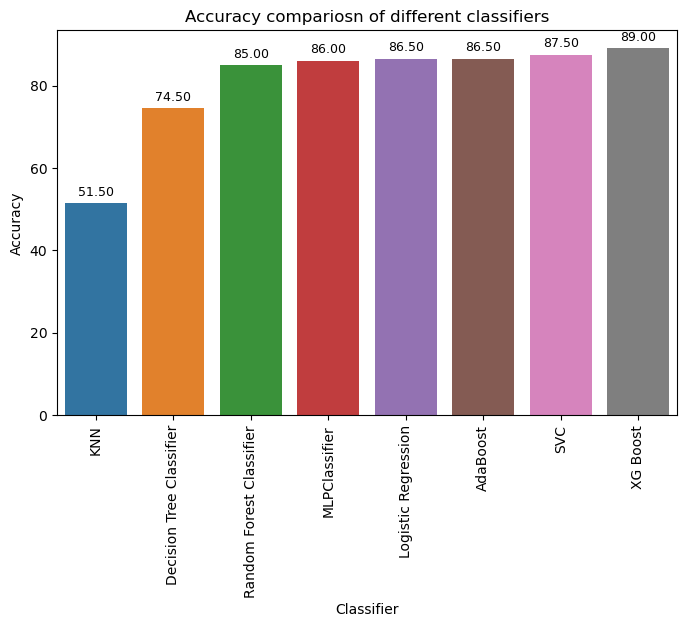

In [24]:
plt.figure(figsize=(8,5))
plt.title('Accuracy compariosn of different classifiers')
ax=sns.barplot(x=model_info['Classifier'],y=model_info['Accuracy'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),(p.get_x() + p.get_width()-0.4,p.get_height()), 
                ha='center', va='center',size=9, xytext=(0, 8),textcoords='offset points')
plt.xticks(rotation=90)
plt.show()